# Set up

In [1]:
# set up 

# force Jupyter to update loaded modules as they change 
%load_ext autoreload
%autoreload 2

Please download and add the folder from the exercise page to the root directory of this project. 
The folder name should be **data** to prevent it from pushing to GitHub. The folder contains following files: 

-- baseline_embeddings_disorder.h5     
-- disorder_seq.fasta    
-- README.md      
-- disorder_labels.fasta     
-- MSAs      
 
**TO DO**: add a method for automatical download.

Run the next cell to display the structure of the repo: 

In [9]:
!ls

data  methods  README.md  visualization  workflow.ipynb


**methods** 
-- utils    
-- nn
 Contains the actual code for pre-processing and definition of our NN. 

**visualization** 
Contains methods for ploting and the output folder with images. 

This notebook is meant to be kinda main driver which imports all methods and performs machine learning pipeline in abstract high-level calls. It means: we will implement the actual dataset import, network definition and training here by importing an appropriate function into the notebook. 

# 0. Prepare the dataset

In [4]:
import methods.nn.disorder_dataset as dd

# a unzipped folder downloaded from the exercises page 
data_folder = 'data'
df = dd.create_dataframe(data_folder)

Reading embeddings...done! Found 1102 proteins.
Reading Z-scores...done! Found 1102 proteins.
Matching protein IDs...done!


In [5]:
df

,x,y
0,"[[0.43359375, -0.09710693, 0.27978516, 0.15466...","[999.0, 11.111, 14.478, 14.995, 15.417, 14.613..."
1,"[[-0.09112549, -0.27441406, -0.19519043, 0.035...","[999.0, 10.238, 12.946, 12.576, 13.361, 13.28,..."
2,"[[-0.21716309, -0.32861328, 0.022506714, 0.225...","[999.0, 999.0, 999.0, 0.008, -0.397, -0.627, -..."
3,"[[-0.2524414, -0.093811035, -0.03062439, 0.032...","[999.0, 999.0, 999.0, 999.0, 999.0, 999.0, 999..."
4,"[[-0.12915039, -0.26342773, 0.1394043, 0.35156...","[999.0, 9.479, 12.204, 14.19, 14.874, 15.397, ..."
...,...,...
1097,"[[0.043792725, -0.16442871, -0.23718262, 0.113...","[999.0, 999.0, 3.487, 3.487, 0.073, 999.0, 999..."
1098,"[[-0.041107178, -0.22106934, -0.34399414, 0.43...","[999.0, 5.685, 5.685, -0.44, 999.0, 999.0, 999..."
1099,"[[0.0413208, -0.33862305, 0.0869751, 0.2056884...","[999.0, 2.996, 3.144, 2.354, -0.951, -3.404, -..."
1100,"[[0.09588623, -0.039520264, -0.005092621, 0.41...","[999.0, 999.0, 999.0, 999.0, 999.0, 999.0, 999..."


In [6]:
print(" Example of a protein embedding")
df['x'][1]

 Example of a protein embedding


array([[-0.09112549, -0.27441406, -0.19519043, ...,  0.07073975,
        -0.1295166 , -0.06420898],
       [-0.29052734, -0.25610352, -0.0814209 , ...,  0.3696289 ,
        -0.09240723,  0.10168457],
       [-0.36010742, -0.15673828, -0.35766602, ...,  0.20019531,
        -0.14501953,  0.07794189],
       ...,
       [-0.05996704, -0.05941772,  0.02037048, ...,  0.11663818,
        -0.05944824, -0.16064453],
       [-0.11566162, -0.0524292 ,  0.37231445, ..., -0.04959106,
        -0.01567078, -0.13586426],
       [-0.1829834 , -0.04116821,  0.29858398, ...,  0.02999878,
        -0.2919922 ,  0.08349609]], dtype=float32)

In [7]:
print(" Example of a z-values for that embedding")
df['y'][1]

 Example of a z-values for that embedding


array([999.   ,  10.238,  12.946,  12.576,  13.361,  13.28 ,  14.732,
        14.657,  14.645,  13.357,  13.654,  12.42 ,  13.782,  13.231,
        14.305,  12.597,  12.195,  12.758,  14.452,  14.832,  14.964,
        14.06 ,  13.621,  14.018,  14.93 ,  16.15 ,  15.118,  14.69 ,
        13.673,  13.872,  13.251,  14.293,  15.191,  15.82 ,  15.464,
        13.134,  10.934,   8.621,  10.775,  12.847,  14.391,  15.203,
        15.389,  15.242,  14.724,  14.087,  12.505,  10.857,  10.88 ,
        11.306,  10.07 ,   6.288,   2.861, 999.   ])

# 1. Visualize the dataset

Reading Z-scores...done! Found 1102 proteins.
Plotting histogram of all z-scores...done! 125223 usable z-scores in total. 5.05% of all z-scores were unknown and hence removed from the histogram.
Plotting histogram of the protein lengths...done! Median length: 114.0.


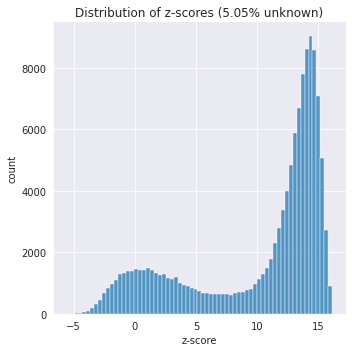

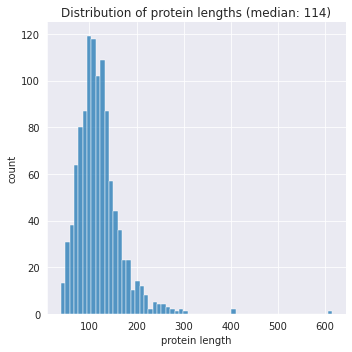

In [8]:
import visualization.visualize_dataset as vis
from methods.utils.read_embeddings import read_z_scores

z_scores = read_z_scores(z_score_file="./data/disorder_labels.fasta")
vis.plot_z_score_histogram(z_scores)
vis.plot_protein_length_histogram(z_scores)